# Определение перспективного тарифа для телеком компании

### Описание проекта

Клиентам предлагают два тарифных плана. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В нашем распоряжении данные 500 пользователей компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


# Оглавление

* [Шаг 1. Общая информация](#chapter1)
    * [Описание данных](#section_1_1)
* [Шаг 2. Предобработка данных](#chapter2)
    * [2.1. Анализ общей информации](#section_2_1)
    * [2.2. Столбцы с датой-временем](#section_2_2)
    * [2.3. Гистограммы по сырым данным](#section_2_3)
        * [2.3.1. Таблица users](#section_2_3_1)
        * [2.3.2. Таблица calls](#section_2_3_2)
        * [2.3.3. Таблица messages](#section_2_3_3)
        * [2.3.4. Таблица internet](#section_2_3_4)
        * [2.3.5. Помесячная выручка](#section_2_3_5)
        
* [Шаг 3. Анализ данных](#chapter3)
* [Шаг 4. Проверка гипотез](#chapter4)
    * [4.1. Гипотеза 1](#section_4_1)
    * [4.2. Гипотеза 2](#section_4_2)
* [Шаг 5. Общий вывод](#chapter5)

# Шаг 1. Общая информация <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
import math
import seaborn as sns
from scipy.stats import levene

## Описание данных <a class="anchor" id="section_1_1"></a>

Откроем файлы с данными и изучим общую информацию.

In [2]:
calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv')
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')

Таблица **users** (информация о пользователях):

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.shape[0]

500

- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

Таблица **calls** (информация о звонках):

In [5]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
calls.shape[0]

202607

- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

Таблица **messages** (информация о сообщениях):

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.shape[0]

123036

- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях):

In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.shape[0]

149396

- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

Таблица **tariffs** (информация о тарифах):

In [11]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Шаг 2. Предобработка данных <a class="anchor" id="chapter2"></a>

## 2.1. Анализ общей информации <a class="anchor" id="section_2_1"></a>

In [12]:
tables = [
    users
    ,calls 
    ,internet
    ,messages
    ,tariffs]

Проанализируем общую информацию о датафреймах.

In [13]:
# Функция возвращает имя датафрейма
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [14]:
# Функция возвращает информацию по каждому датафрейму из списка.
def pre_check(df_list):
    for df in df_list:
        print('=================================')
        print(get_df_name(df))
        print('_________________________________')
        print(df.info())
        print('Количество дубликатов: ', df.duplicated().sum())
        print('_________________________________')

In [15]:
pre_check(tables)

users
_________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
Количество дубликатов:  0
_________________________________
calls
_________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non

В таблице **calls** округлим продолжительность звонков до минут в большую сторону, чтобы далее правильно посчитать выручку.

In [16]:
calls['duration'] =  calls['duration'].apply(math.ceil)

## 2.2. Столбцы с датой-временем <a class="anchor" id="section_2_2"></a>

В каждой из таблиц есть поле с датой в строковом формате "Год-Месяц-День". Переведём их в Unix time и добавам в каждый датафрейм сооответствующие столбцы.

In [17]:
date_format='%Y-%m-%d'

In [18]:
# Функция возвращает Series с годом
def create_year_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    year_column = unix_time.dt.year
    return(year_column)

In [19]:
# Функция возвращает Series с месяцем
def create_month_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    month_column = unix_time.dt.month
    return(month_column)

In [20]:
# Функция возвращает Series с днём
def create_day_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    day_column = unix_time.dt.day
    return(day_column)

In [21]:
# Функция возвращает Series с днём недели
def create_weekday_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    weekday_column = unix_time.dt.weekday
    return(weekday_column)

In [22]:
# Функция, которая вставляет в датафрейм колонки с годом, месяцем, числом месяца и днём недели 

def add_ymdwd_columns(df, prefix, datetime_str_columnname, format):
    """
    df - датафрейм, в который нужно вставить колонки
    prefix - префикс для имени новой колонки
    datetime_str_columnname - имя колонки, где лежит дата-время в строковом формате
    format - строка с форматом колонки datetime_str_columnname        
    """
    year_name = prefix + "year"
    df[year_name] = create_year_column(df, datetime_str_columnname, format)
    month_name = prefix + "month"
    df[month_name] = create_month_column(df, datetime_str_columnname, format)
    day_name = prefix + "day"
    df[day_name] = create_day_column(df, datetime_str_columnname, format)
    weekday_name = prefix + "weekday"
    df[weekday_name] = create_weekday_column(df, datetime_str_columnname, format)

Создадим словарь для нашей функции.

In [88]:
fields_dict = pd.DataFrame({
    'df': [users,calls,internet,messages],
    'prefix': ['reg_','call_','session_','message_'],
    'field': ['reg_date','call_date','session_date','message_date']
})

In [89]:
fields_dict

,df,prefix,field
0,user_id age churn_date city fir...,reg_,reg_date
1,id call_date duration user_i...,call_,call_date
2,Unnamed: 0 id mb_used session_...,session_,session_date
3,id message_date user_id messag...,message_,message_date


Прогоним в цикле функцию, создающую поля с годом, месяцем, числом месяца и днём недели.

In [24]:
for row in range(0, len(fields_dict)):
    add_ymdwd_columns(fields_dict.loc[row]['df'], \
                    fields_dict.loc[row]['prefix'], \
                    fields_dict.loc[row]['field'], \
                    date_format)

In [25]:
pre_check(tables)

users
_________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      500 non-null    int64 
 1   age          500 non-null    int64 
 2   churn_date   38 non-null     object
 3   city         500 non-null    object
 4   first_name   500 non-null    object
 5   last_name    500 non-null    object
 6   reg_date     500 non-null    object
 7   tariff       500 non-null    object
 8   reg_year     500 non-null    int64 
 9   reg_month    500 non-null    int64 
 10  reg_day      500 non-null    int64 
 11  reg_weekday  500 non-null    int64 
dtypes: int64(6), object(6)
memory usage: 47.0+ KB
None
Количество дубликатов:  0
_________________________________
calls
_________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 8 columns):
 #   Column    

Мы создали из столбцов с датой-временем отдельные колонки с годом, месяцем, числом месяца и днём недели.

## 2.3. Гистограммы по сырым данным <a class="anchor" id="section_2_3"></a>

### 2.3.1. Таблица *users*<a class="anchor" id="section_2_3_1"></a>

- Откуда большинство пользователей в выборке? Какими тарифами они пользуются?

In [26]:
cities_smart = users[users['tariff'] == 'smart']['city'].value_counts()
cities_ultra = users[users['tariff'] == 'ultra']['city'].value_counts()

Всего пользователей тарифа SMART: 351


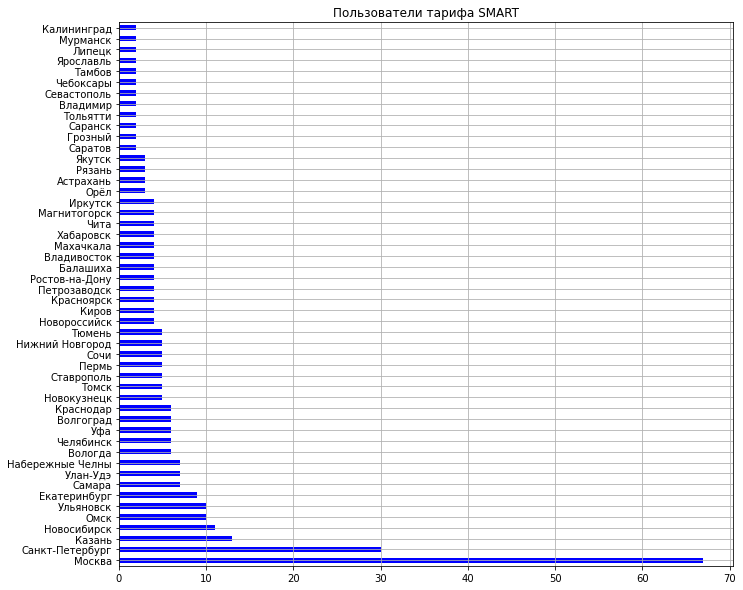

Всего пользователей тарифа ULTRA: 149


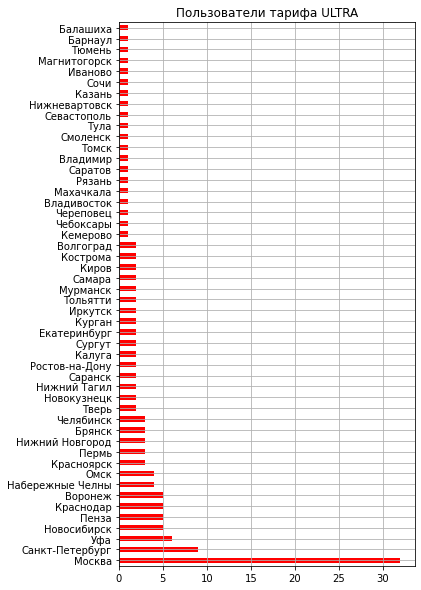

In [27]:
plt.title('Пользователи тарифа SMART')
cities_smart.head(50).plot(kind='barh',linewidth=5, color='blue',figsize=(11, 10), grid=True)
print('Всего пользователей тарифа SMART:', cities_smart.sum())
plt.show()
plt.title('Пользователи тарифа ULTRA')
cities_ultra.head(50).plot(kind='barh',linewidth=5, color='red',figsize=(5.3, 10), grid=True)
print('Всего пользователей тарифа ULTRA:', cities_ultra.sum())

Большинство пользователей в нашей выборке из Москвы и Санкт-Петербурга. При этом в нашей выборке пользователей тарифа SMART в 2.3 раза больше, чем пользователей тарифа ULTRA.

In [28]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_year,reg_month,reg_day,reg_weekday
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018,11,1,3
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018,6,17,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,2018,8,17,4
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018,5,14,0


- Когда пользователи подключали тарифы?

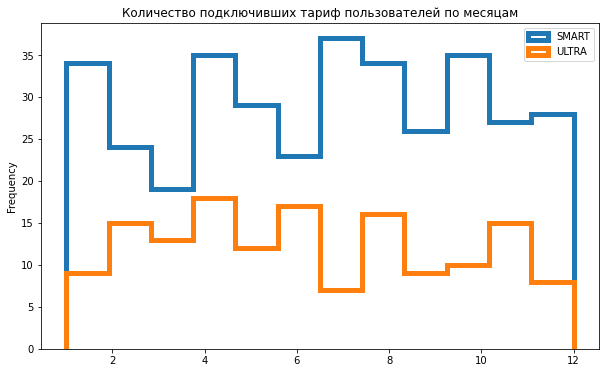

In [29]:
plt.figure(figsize=(10,6))
plt.title('Количество подключивших тариф пользователей по месяцам')
ax0 = users[users['tariff'] == 'smart']['reg_month']\
.plot(kind='hist', bins=12, linewidth=5, histtype='step', label='SMART')
ax1 = users[users['tariff'] == 'ultra']['reg_month']\
.plot(kind='hist', bins=12, linewidth=5, histtype='step', label='ULTRA')
ax0.legend()

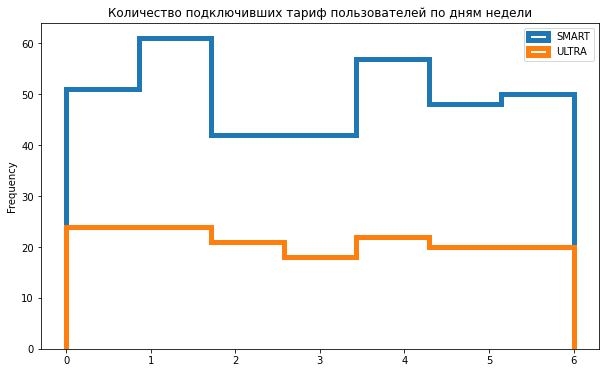

In [30]:
plt.figure(figsize=(10,6))
plt.title('Количество подключивших тариф пользователей по дням недели')
ax0 = users[users['tariff'] == 'smart']['reg_weekday']\
.plot(kind='hist', bins=7, linewidth=5, histtype='step', label='SMART')
ax1 = users[users['tariff'] == 'ultra']['reg_weekday']\
.plot(kind='hist', bins=7, linewidth=5, histtype='step', label='ULTRA')
ax0.legend();

Количество новфх пользователей тарифа SMART резко подскочило в июле, а количество новых пользователей тарифа ULTRA напротив, упало в этом же месяце. 

In [31]:
def age_group(age):
        """
        Возвращает id возрастной группы по значению возраста age, используя правила:
        - 'молодые' при значении age <= 35 лет
        - 'взрослые' при значениии age более 35 и менее 64, включая 64
        - 'пожилые' во всех остальных случаях
        """

        if age <= 20:
                return  10 #'молодые'
        if age <= 30:
                return  20 
        if age <= 40:
                return  30 
        if age <= 50:
                return  40
        if age <= 60:
                return  50        
        if age <= 70:
                return  60
        if age <= 80:
                return  70    
            #'взрослые'
        return 80 #'пожилые' 

In [32]:
users['age_group_id'] = users['age'].apply(age_group)

- Какими тарифами пользуются разные возрастные группы?

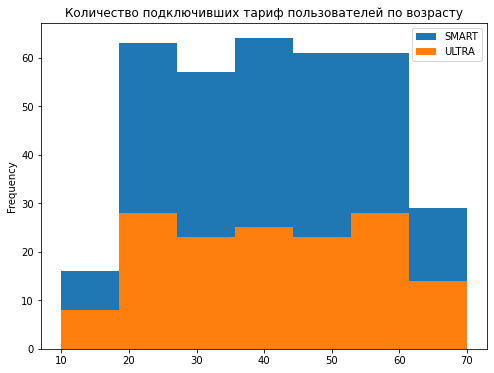

In [33]:
plt.figure(figsize=(8,6))
plt.title('Количество подключивших тариф пользователей по возрасту')
ax0 = users[users['tariff'] == 'smart']['age_group_id']\
.plot(kind='hist', bins=7, label='SMART')
ax1 = users[users['tariff'] == 'ultra']['age_group_id']\
.plot(kind='hist', bins=7, label='ULTRA')
ax0.legend()

В нашей выборке тариф не зависит от возрастной группы.

### Функции для построения графиков

In [34]:
# Функция для вычисления перцентиля
def get_percentile(df, column_name, percentile_rank):
    
    # Удалим NaN в столбце, отсортируем df, сбросим индексы
    try:
        # Если на входе - dataframe
        df = df.dropna(subset=[column_name]).sort_values(by=column_name).reset_index()
    except:
        # Если на входе - series
        df = df.dropna().sort_values().reset_index()
    # Найдём индекс перцентиля
    index = (len(df.index)-1) * percentile_rank / 100.0
    index = int(index)
    value = df.at[index, column_name]
    # Вернём элемент с этим индексом
    return value

In [35]:
# Функция для вычисления интерквартильного размаха.
def interquartile_range(df, column_name):
    
    p75 = get_percentile(df, column_name, 75)  # 75-й перцентиль
    p25 = get_percentile(df, column_name, 25)  # 25-й перцентиль
    iqr = p75 - p25  # интерквартильный размах
    return iqr

In [36]:
# Функция для вычисления левого уса.
def left_mustache(df, column_name):
    p25 = get_percentile(df, column_name, 25)
    iqr = interquartile_range(df, column_name)
    p0 = get_percentile(df, column_name, 0)
    if p25 - iqr*1.5 < p0:
        return (p0)
    return(p25 - iqr*1.5)

In [37]:
# Функция для вычисления правого уса
def right_mustache(df, column_name):
    p75 = get_percentile(df, column_name, 75)
    iqr = interquartile_range(df, column_name)
    p100 = get_percentile(df, column_name, 100)
    if p75 + iqr*1.5 > p100:
        return (p100)
    return(p75 + iqr*1.5)

In [38]:
# Функция для построения гистограммы по значениям, входящим в ящик с усами.
def box_mustache_hist(df, column_name, bins, title=False):
    
    # Отсортируем df, сбросим индексы
    df = df.sort_values(by=column_name).reset_index()
    split = df.loc[(df.loc[:, column_name] >= left_mustache(df, column_name))\
                  &(df.loc[:, column_name] <= right_mustache(df, column_name))][column_name]
    plt.figure(figsize=(9,5))
    plt.hist(split, bins=bins)
    if title == False:
        plt.title(column_name)
    else:
        plt.title(title)
    # Вертикальные линии для каждого перцентиля
    plt.axvline(get_percentile(df, column_name, 25), linestyle='--', color='red')
    plt.axvline(get_percentile(df, column_name, 50), linestyle='-',  color='red')
    plt.axvline(get_percentile(df, column_name, 75), linestyle='--', color='red')
    plt.show()
    print('Среднее значение: ', round(df[column_name].mean(),2))
    print('Стандартное отклонение: ', round(df[column_name].std(),2))
    print('Медиана: ', get_percentile(df, column_name, 50))

### Функция для аггрегации по по второй из двух группировок

In [39]:
# Функция для аггрегации значений по сгруппированным на двух уровнях значениям
# Возвращает таблицу с тремя столбцами: первым и вторым уровнями группировки и аггрегированным значением
def agg_by_2lvls(df, first_level, second_level, value, aggfunc):
    pivot = df.pivot_table(index=(first_level,second_level),values=value, aggfunc=aggfunc)
    pivot_rstd = pivot.reset_index()
    name_aggregated = get_df_name(df) +"_" + value + "_" + aggfunc
    pivot_rstd.columns = [first_level,second_level,name_aggregated]
    return pivot_rstd

### 2.3.2. Таблица *calls*<a class="anchor" id="section_2_3_2"></a>

In [40]:
calls.head()

,id,call_date,duration,user_id,call_year,call_month,call_day,call_weekday
0,1000_0,2018-07-25,0,1000,2018,7,25,2
1,1000_1,2018-08-17,0,1000,2018,8,17,4
2,1000_2,2018-06-11,3,1000,2018,6,11,0
3,1000_3,2018-09-21,14,1000,2018,9,21,4
4,1000_4,2018-12-15,6,1000,2018,12,15,5


In [41]:
calls.shape[0]

202607

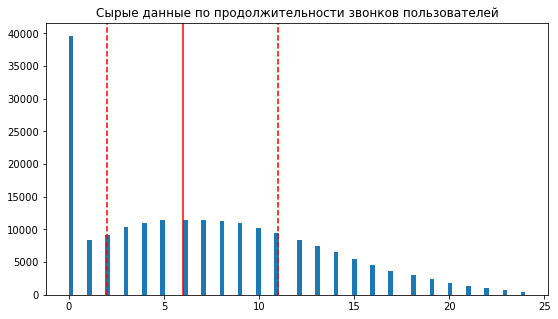

Среднее значение:  7.16
Стандартное отклонение:  5.96
Медиана:  6


In [42]:
box_mustache_hist(calls, 'duration', 100, 'Сырые данные по продолжительности звонков пользователей')

Длительность многих звонков - 0.0 минут. Скорее всего, это пропущенные звонки. Для нашего исследования они не репрезентативны, однако мы всё равно выделим их в отдельный датафрейм на всякий случай, чтобы исследовать. Посмотрим, когда было больше всего пропущенных вызовов.

In [43]:
missed_calls = calls[calls['duration'] == 0]

In [44]:
print('Выбрасываем ', missed_calls.shape[0], ' нерепрезентативных строк из выборки в ', calls.shape[0], ' строк.')

Выбрасываем  39613  нерепрезентативных строк из выборки в  202607  строк.


Оставим в **calls** только звонки ненулевой длительности.

In [45]:
calls = calls[calls['duration'] > 0]

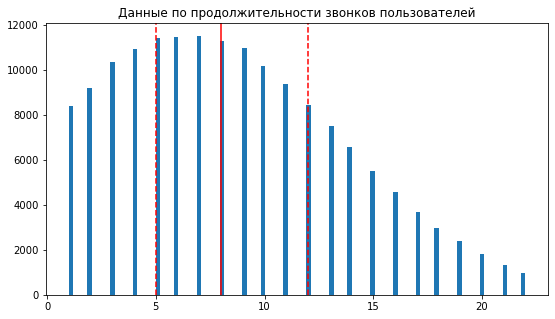

Среднее значение:  8.9
Стандартное отклонение:  5.35
Медиана:  8


In [46]:
box_mustache_hist(calls, 'duration', 100, 'Данные по продолжительности звонков пользователей')

Среднее и медиана увеличились относительно сырых данных, а стандартное отклонение уменьшилось.

- Посчитаем количество сделанных звонков для каждого пользователя по месяцам. Положим результат в таблицу **calls_count_by_month**.

In [47]:
calls_count_by_month = agg_by_2lvls(calls, 'call_month', 'user_id', 'id', 'count')
calls_count_by_month

,call_month,user_id,calls_id_count
0,1,1005,11
1,1,1032,44
2,1,1045,1
3,1,1055,47
4,1,1071,18
...,...,...,...
3163,12,1494,54
3164,12,1495,120
3165,12,1496,65
3166,12,1497,58


Заменим имя колонки с месяцем на *month* 

In [48]:
calls_count_by_month.columns = ['month', 'user_id', 'calls_id_count']
calls_count_by_month.columns

Index(['month', 'user_id', 'calls_id_count'], dtype='object')

- Посчитаем количество израсходованных минут для каждого пользователя по месяцам. Положим результат в таблицу **calls_duration_by_month**.

In [49]:
calls_duration_by_month = agg_by_2lvls(calls, 'call_month', 'user_id', 'duration', 'sum')
calls_duration_by_month

,call_month,user_id,calls_duration_sum
0,1,1005,95
1,1,1032,380
2,1,1045,9
3,1,1055,551
4,1,1071,194
...,...,...,...
3163,12,1494,418
3164,12,1495,1031
3165,12,1496,518
3166,12,1497,545


Заменим имя колонки с месяцем на *month* 

In [50]:
calls_duration_by_month.columns = ['month', 'user_id', 'calls_duration_sum']
calls_duration_by_month.columns

Index(['month', 'user_id', 'calls_duration_sum'], dtype='object')

### 2.3.3. Таблица *messages*<a class="anchor" id="section_2_3_3"></a>

In [51]:
messages.head()

,id,message_date,user_id,message_year,message_month,message_day,message_weekday
0,1000_0,2018-06-27,1000,2018,6,27,2
1,1000_1,2018-10-08,1000,2018,10,8,0
2,1000_2,2018-08-04,1000,2018,8,4,5
3,1000_3,2018-06-16,1000,2018,6,16,5
4,1000_4,2018-12-05,1000,2018,12,5,2


- Посчитаем количество отправленных каждым пользователем сообщений по месяцам. Положим результат в таблицу **messages_count_by_month**.

In [52]:
messages_count_by_month = agg_by_2lvls(messages, 'message_month', 'user_id', 'id', 'count')
messages_count_by_month

,message_month,user_id,messages_id_count
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


Заменим имя колонки с месяцем на *month* 

In [53]:
messages_count_by_month.columns = ['month', 'user_id', 'messages_id_count']
messages_count_by_month.columns

Index(['month', 'user_id', 'messages_id_count'], dtype='object')

### 2.3.4. Таблица *internet*<a class="anchor" id="section_2_3_4"></a>

In [54]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,session_year,session_month,session_day,session_weekday
0,0,1000_0,112.95,2018-11-25,1000,2018,11,25,6
1,1,1000_1,1052.81,2018-09-07,1000,2018,9,7,4
2,2,1000_2,1197.26,2018-06-25,1000,2018,6,25,0
3,3,1000_3,550.27,2018-08-22,1000,2018,8,22,2
4,4,1000_4,302.56,2018-09-24,1000,2018,9,24,0


Оценим сырые данные по трафику с точки зрения выбросов.

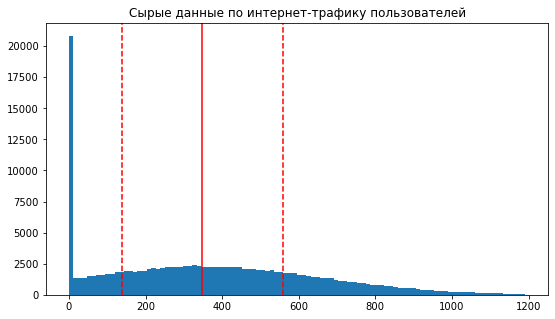

Среднее значение:  370.19
Стандартное отклонение:  278.3
Медиана:  348.01


In [55]:
box_mustache_hist(internet, 'mb_used', 100, 'Сырые данные по интернет-трафику пользователей')

Как и в случае со звонками, отбросим данные, где трафик сессии равен 0.0 Мб. Данные о таких сессиях ничего не репрезентативны и влияют на среднее, тандартное отклонение и медиану.

In [56]:
missed_sessions = internet[internet['mb_used'] == 0]

In [57]:
print('Выбрасываем ', missed_sessions.shape[0], ' нерепрезентативных строк из выборки в ', internet.shape[0], ' строк.')

Выбрасываем  19598  нерепрезентативных строк из выборки в  149396  строк.


Оставим в **internet** только сессии с ненулевым трафиком.

In [58]:
internet = internet[internet['mb_used'] > 0]

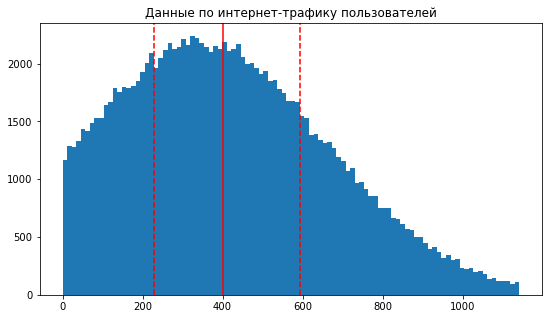

Среднее значение:  426.09
Стандартное отклонение:  255.6
Медиана:  400.54


In [59]:
box_mustache_hist(internet, 'mb_used', 100, 'Данные по интернет-трафику пользователей')

- Посчитаем суммарный трафик каждого пользователя по месяцам. Положим результат в таблицу **internet_sum_by_month**.

In [60]:
internet_sum_by_month = agg_by_2lvls(internet, 'session_month', 'user_id', 'mb_used', 'sum')
internet_sum_by_month

,session_month,user_id,internet_mb_used_sum
0,1,1005,2727.97
1,1,1032,24127.69
2,1,1045,2346.71
3,1,1055,17090.88
4,1,1071,15604.34
...,...,...,...
3196,12,1494,17621.21
3197,12,1495,23426.76
3198,12,1496,20736.15
3199,12,1497,19918.60


Заменим имя колонки с месяцем на *month* 

In [61]:
internet_sum_by_month.columns = ['month', 'user_id', 'internet_mb_used_sum']
internet_sum_by_month.columns

Index(['month', 'user_id', 'internet_mb_used_sum'], dtype='object')

### 2.3.5.  Помесячная выручка<a class="anchor" id="section_2_3_5"></a>

Посмотрим еще раз на размеры полученных таблиц. Так как тарифом не ограничено количество звонков, а только количество потраченных минут, то нам не понадобится сейчас таблица calls_count_by_month.

In [62]:
print(internet_sum_by_month.shape[0],
      calls_duration_by_month.shape[0],
      messages_count_by_month.shape[0])

3201 3168 2717


Объединим эти таблицы c таблицей **users**.

In [63]:
users_data = users.merge(internet_sum_by_month, on='user_id', how='outer')
users_data.shape[0]

3204

In [64]:
users_data['calls_duration_sum'] = users_data.merge(calls_duration_by_month, on='user_id', how='outer')['calls_duration_sum']
users_data.shape[0]

3204

In [65]:
users_data['messages_id_count'] = users_data.merge(messages_count_by_month, on='user_id', how='outer')['messages_id_count']
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_year,reg_month,reg_day,reg_weekday,age_group_id,month,internet_mb_used_sum,calls_duration_sum,messages_id_count
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,5.0,2253.49,159.0,22.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,6.0,23233.77,172.0,60.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,7.0,14003.64,340.0,75.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,8.0,14055.93,408.0,81.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,9.0,14568.91,466.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018,7,19,3,60,10.0,20579.36,313.0,20.0
3200,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,2018,9,27,3,30,9.0,1845.75,402.0,22.0
3201,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,2018,9,27,3,30,10.0,17788.51,479.0,19.0
3202,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,2018,9,27,3,30,11.0,17963.31,277.0,24.0


In [66]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3204 entries, 0 to 3203
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               3204 non-null   int64  
 1   age                   3204 non-null   int64  
 2   churn_date            188 non-null    object 
 3   city                  3204 non-null   object 
 4   first_name            3204 non-null   object 
 5   last_name             3204 non-null   object 
 6   reg_date              3204 non-null   object 
 7   tariff                3204 non-null   object 
 8   reg_year              3204 non-null   int64  
 9   reg_month             3204 non-null   int64  
 10  reg_day               3204 non-null   int64  
 11  reg_weekday           3204 non-null   int64  
 12  age_group_id          3204 non-null   int64  
 13  month                 3201 non-null   float64
 14  internet_mb_used_sum  3201 non-null   float64
 15  calls_duration_sum   

Мы получили таблицу **users_data**, в которой есть интересующая нас информация - сгруппированные по месяцам и пользователям количество израсходованных минут, сообщений и трафика. Заменим все NaN нулями.

In [67]:
users_data = users_data.fillna(0)

Создадим по таблице **tariffs** словарь, в котором ключами будут названия тарифов.

In [68]:
tariff_dict = tariffs.set_index('tariff_name').T.to_dict('list')
tariff_dict

{'smart': [50, 15360, 500, 550, 200, 3, 3],
 'ultra': [1000, 30720, 3000, 1950, 150, 1, 1]}

Напишем функцию для расчёта дохода с каждого пользователя.

In [69]:
# Функция для вычисления дохода с каждого пользователя
def income(row):
    tariff = row['tariff']
    if row['tariff'] in tariff_dict.keys():
        messages_included = tariff_dict[tariff][0]
        mb_per_month_included = tariff_dict[tariff][1]
        minutes_included = tariff_dict[tariff][2]
        rub_monthly_fee = tariff_dict[tariff][3]
        rub_per_gb = tariff_dict[tariff][4]
        rub_per_message = tariff_dict[tariff][5]
        rub_per_minute = tariff_dict[tariff][6]
    else:
         return(print('Нет такого тарифа в tariffs'))
    #  Минуты:   
    differance_min = row['calls_duration_sum'] - minutes_included
    if differance_min <= 0:
        income = rub_monthly_fee
    else:
        income = rub_monthly_fee + differance_min * rub_per_minute
    # Сообщения:    
    differance_mes = row['messages_id_count'] - messages_included
    if differance_mes <= 0:
        income = income 
    else:
        income = income + differance_mes * rub_per_message        
    # Трафик:
    differance_int = row['internet_mb_used_sum'] - mb_per_month_included
    if differance_int <= 0:
        income = income 
    else:
        income = income + math.ceil(differance_int/1024) * rub_per_gb
    
    return (income)

Применим нашу функцию к датафрейму **users_data**.

In [70]:
users_data['income'] = users_data.apply(income, axis=1)

In [71]:
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_year,reg_month,reg_day,reg_weekday,age_group_id,month,internet_mb_used_sum,calls_duration_sum,messages_id_count,income
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,5.0,2253.49,159.0,22.0,1950.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,6.0,23233.77,172.0,60.0,1950.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,7.0,14003.64,340.0,75.0,1950.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,8.0,14055.93,408.0,81.0,1950.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018,5,25,4,50,9.0,14568.91,466.0,57.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018,7,19,3,60,10.0,20579.36,313.0,20.0,1750.0
3200,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,2018,9,27,3,30,9.0,1845.75,402.0,22.0,550.0
3201,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,2018,9,27,3,30,10.0,17788.51,479.0,19.0,1150.0
3202,1499,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,2018,9,27,3,30,11.0,17963.31,277.0,24.0,1150.0


Получили колонку *income*, в которой лежит выручка с каждого пользователя за месяц.

# Шаг 3. Анализ данных <a class="anchor" id="chapter3"></a>

Напишем функцию для построения графиков плотностей вероятности.

In [72]:
df1 = users_data.loc[(users_data['tariff']=='ultra')]
df2 = users_data.loc[(users_data['tariff']=='smart')]
def pd_tariffs_compare(df1, df2, column, title, setpoint1, setpoint2):
    ultra = df1[column]
    smart = df2[column]

    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.kdeplot(ultra, color='r', shade=True, Label='ultra')
    sns.kdeplot(smart, color='b', shade=True, Label='smart')
    plt.xlabel(column) 
    plt.ylabel('Probability Density')
    plt.axvline(setpoint1, linestyle='-', color='red')
    plt.axvline(setpoint2, linestyle='-', color='blue')
    plt.show()
    print("Медиана ultra: ", "p50 =", int(get_percentile(ultra, column, 50)))
    print("Медиана smart: ", "p50 =", int(get_percentile(smart, column, 50)))
    print("Среднее ultra: ", "μ =", round(ultra.mean()))
    print("Среднее smart: ", "μ =", round(smart.mean()))
    print("Дисперсия ultra: ", "s^2 =", round(np.var(ultra, ddof=1)))
    print("Дисперсия smart: ", "s^2 =", round(np.var(smart, ddof=1)))
    print("Стандартное отклонение ultra: ", "s =", round(np.std(ultra, ddof=1)))
    print("Стандартное отклонение smart: ", "s =", round(np.std(smart, ddof=1)))    

C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill

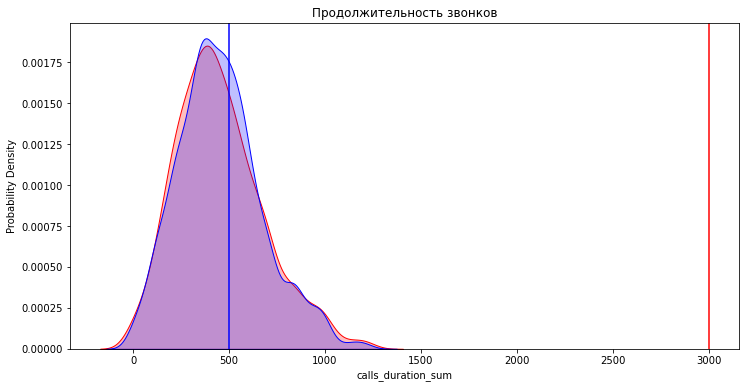

Медиана ultra:  p50 = 420
Медиана smart:  p50 = 437
Среднее ultra:  μ = 449
Среднее smart:  μ = 452
Дисперсия ultra:  s^2 = 52311
Дисперсия smart:  s^2 = 48329
Стандартное отклонение ultra:  s = 229
Стандартное отклонение smart:  s = 220


In [73]:
pd_tariffs_compare(df1, df2, 'calls_duration_sum', 'Продолжительность звонков', 3000, 500)

C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill

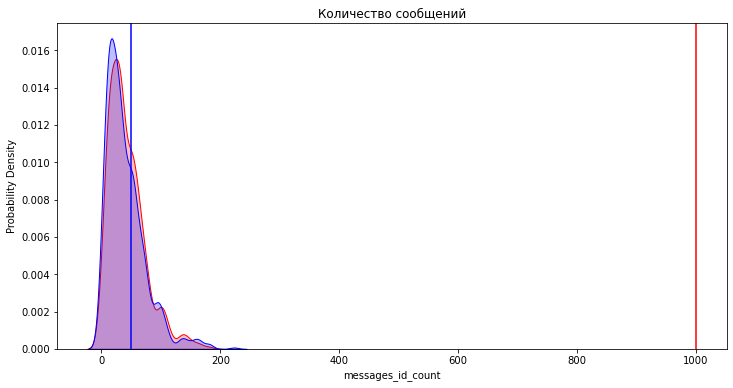

Медиана ultra:  p50 = 35
Медиана smart:  p50 = 31
Среднее ultra:  μ = 42
Среднее smart:  μ = 40
Дисперсия ultra:  s^2 = 975
Дисперсия smart:  s^2 = 1097
Стандартное отклонение ultra:  s = 31
Стандартное отклонение smart:  s = 33


In [74]:
pd_tariffs_compare(df1, df2, 'messages_id_count', 'Количество сообщений', 1000, 50)

C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
C:\Users\shepelev.ao\Anaconda3\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill

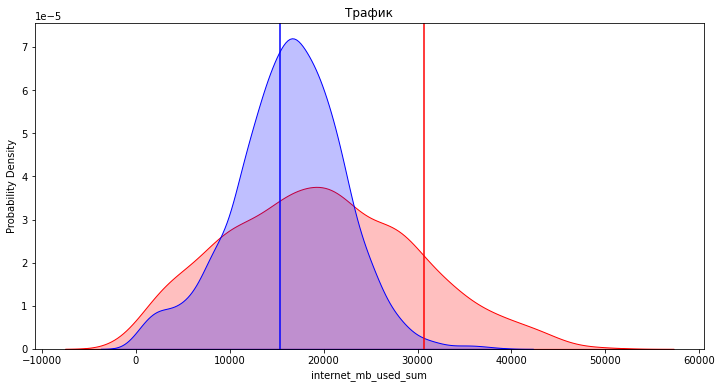

Медиана ultra:  p50 = 19376
Медиана smart:  p50 = 16506
Среднее ultra:  μ = 19648
Среднее smart:  μ = 16216
Дисперсия ultra:  s^2 = 99159212
Дисперсия smart:  s^2 = 34359952
Стандартное отклонение ultra:  s = 9958
Стандартное отклонение smart:  s = 5862


In [75]:
pd_tariffs_compare(df1, df2, 'internet_mb_used_sum', 'Трафик', 30720, 15360)

**Вывод.**

В случае минут разговора и сообщений мы имеем похожие картины для обоих тарифов. Оба распределения похожи на нормальное, скошенное вправо. Об этом говорит и сравнение их медиан со средними значениями: в обоих случаях среднее больше.

Пользователи тарифа "smart" в нашей выборке в среднем на 3 минуты дольше разговаривают, а пользователи тарифа "ultra" пишут на 2 смс больше. При этом их дисперсии отличаются не слишком сильно.

А вот различия в пользовании интернетом значительно более существенные.
Оба распределения похожи на нормальное, причем у "ultra" есть небольшой скос вправо, а у "smart" - влево. Пользователи тарифа "smart" в нашей выборке с большей вероятностью тратят от 10 до 25 Гб в месяц, чем пользователи тарифа "ultra". При этом больше половины пользователей тарифа "smart" используют дополнительные пакеты интернета (сверх 15 Гб). Большинство пользователей тарифа "ultra" напротив, укладываются в ограничение своего тарифа (30Гб). Они с большей вероятностью могут как использовать больше 25 Гб, так и меньше 7 Гб по сравнению с пользователями тарифа "smart".

# Шаг 4. Проверка гипотез <a class="anchor" id="chapter4"></a>

## 4.1. Гипотеза 1 <a class="anchor" id="section_4_1"></a>

*Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.*

H₀ - в нашей выборке средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H₁ - в нашей выборке средняя выручка пользователей тарифа «Ультра» НЕ равна средней выручке пользователей тарифа «Смарт».

Сначала посмотрим, как распределена плотность вероятности дохода компании по каждому пользователю.

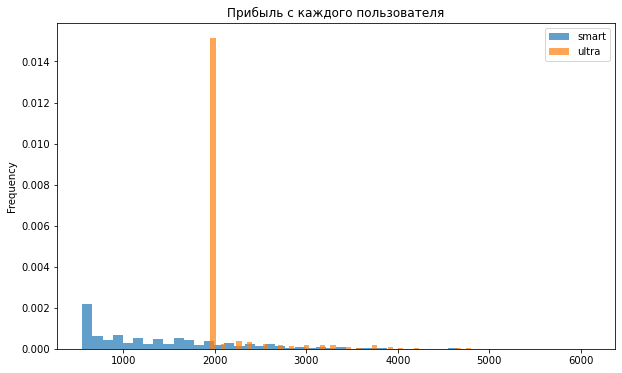

Среднее ultra:  2071
Среднее smart:  1373
Дисперсия ultra:  s^2 = 142689
Дисперсия smart:  s^2 = 653570


In [76]:
plt.figure(figsize=(10,6))
plt.title('Прибыль с каждого пользователя')
smart = users_data[users_data['tariff'] == 'smart']['income']
ultra = users_data[users_data['tariff'] == 'ultra']['income']
ax0 = smart.plot(kind='hist', bins=50, linewidth=5, label='smart', density = True, alpha=0.7)
ax1 = ultra.plot(kind='hist', bins=50, linewidth=5, label='ultra', density = True, alpha=0.7)
ax0.legend()
plt.show()
print("Среднее ultra: ", round(ultra.mean()))
print("Среднее smart: ", round(smart.mean()))
print("Дисперсия ultra: ", "s^2 =", round(np.var(ultra, ddof=1)))
print("Дисперсия smart: ", "s^2 =", round(np.var(smart, ddof=1)))

По гистограмме плотностей видно, что пользователи тарифа «Ультра» из нашей выборки тратят в среднем больше, чем пользователи тарифа «Смарт». Для трат пользователей тарифа «Смарт» дисперсия в несколько раз больше, чем для трат пользователей тарифа «Ультра». Поэтому и график более скошенный.

Создадим две выборки одинакового размера. 

In [77]:
ultra_data = users_data.loc[(users_data['tariff']=='ultra')]['income']
smart_data = users_data.loc[(users_data['tariff']=='smart')]['income']

In [78]:
print(ultra_data.shape[0])
print(smart_data.shape[0])

976
2228


Сравним дисперсии выборок.

In [79]:
[np.var(x, ddof=1) for x in [ultra_data, smart_data]]

[142688.5639974796, 653569.756339489]

Похоже, что дисперсии выборок сильно отличаются. Проверим это. Так как для выборок из существенно ненормальных популяций тест Левена более надежен, чем тест Бартлетта, будем использовать тест Левена:
    
H₀ - выборки взяты из популяций с равной дисперсией.
    
H₁ - выборки взяты из популяций с НЕ равной дисперсией.

In [80]:
stat_p_median = levene(ultra_data, smart_data, center='median')
print('stat_p_median =', stat_p_median)

stat_p_median = LeveneResult(statistic=702.765706625037, pvalue=3.60540424833377e-140)


Мы провели тест Левене относительно медианы (рекомендованному в случае искаженных распределений), и получили очень маленькое pvalue. 

Мы не можем принять нулевую гипотезу о равенстве дисперсий популяций, из которых взяты выборки.
Поэтому при проверке гипотезы через Т-критерий Стьюдента мы будем использовать параметр `equal_var = False` в методе `ttest_ind`.

Проверим гипотезу о равенстве среднего двух генеральных совокупностей (выручка от пользователей «Смарт», выручка от пользователей «Ультра») по взятым из них выборкам. Воспользуемся t-критерием Стьюдента. Так как выборки довольно большие (больше 100), положим уровень статистической значимости равным 1%.

In [81]:
alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    ultra_data, 
    smart_data,
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 6.793343590198285e-209
Отвергаем нулевую гипотезу


**Вывод.**
Мы отвергаем гипотезу о том, что средняя выручка пользователей тарифа «Ультра» РАВНА средней выручки пользователей тарифа «Смарт».

*Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.*

H₀ - в нашей выборке средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H₁ - в нашей выборке средняя выручка пользователей тарифа «Ультра» БОЛЬШЕ средней выручки пользователей тарифа «Смарт».

In [82]:
smart_mean = smart_data.mean()

alpha = .01 # критический уровень статистической значимости

results = st.ttest_1samp(
    ultra_data, 
    smart_mean)

# тест односторонний: p-value будет в два раза меньше
print('p-значение: ', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только если выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (ultra_data.mean() > smart_mean):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  3.9075677e-317
Отвергаем нулевую гипотезу


**Вывод.**
Таким образом, мы принимаем альтернативную гипотезу о том, что тариф «Ультра» приносит больше денег.

## 4.2. Гипотеза 2 <a class="anchor" id="section_4_2"></a>

*Гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.*

H₀ - в нашей выборке средняя выручка пользователей из Москвы равна средней выручке от пользователей из других регионов.

H₁ - в нашей выборке средняя выручка пользователей из Москвы НЕ равна средней выручке от пользователей из других регионов.

In [83]:
moskow_data = users_data.loc[(users_data['city']=='Москва')]['income']
russia_data = users_data.loc[(users_data['city'] !='Москва')]['income']

In [84]:
print(moskow_data.shape[0])
print(russia_data.shape[0])

611
2593


Сравним дисперсии выборок.

In [85]:
[np.var(x, ddof=1) for x in [moskow_data, russia_data]]

[570476.291760347, 608278.5620357894]

Похоже, что дисперсии выборок не слишком сильно отличаются. Проверим это. Так как для выборок из существенно ненормальных популяций тест Левена более надежен, чем тест Бартлетта, будем использовать тест Левена:
    
H₀ - выборки взяты из популяций с равной дисперсией.
    
H₁ - выборки взяты из популяций с НЕ равной дисперсией.

In [86]:
stat_p_mean = levene(moskow_data, russia_data, center='mean')
stat_p_median = levene(moskow_data, russia_data, center='median')
print('stat_p_mean =', stat_p_mean)
print('stat_p_median =', stat_p_median)

stat_p_mean = LeveneResult(statistic=0.1825690356954749, pvalue=0.6692034146503055)
stat_p_median = LeveneResult(statistic=2.1932973492568104, pvalue=0.13871068975348072)


    
- При проведении теста Левене относительно среднего мы получили pvalue=0.67. То есть в случае, если наше распределение нормальное с умеренным хвостом, то мы точно не можем считать, что дисперсии популяций, из которых взяты наши выборки, не равны. 

- При проведении теста Левене относительно медианы мы получили pvalue=0.14. То есть даже в случае, если распределение искаженное (не нормальное), то мы не можем считать, что дисперсии популяций, из которых взяты наши выборки, не равны. 

Мы не можем отвергнуть нулевую гипотезу о равенстве дисперсий популяций, из которых взяты выборки.
Поэтому при проверке гипотезы через Т-критерий Стьюдента мы будем использовать параметр `equal_var = True` в методе `ttest_ind` (по дефолту True).

Проверим гипотезу о равенстве среднего двух генеральных совокупностей (выручка от пользователей Москвы, выручка от пользователей из других регионов) по взятым из них выборкам. Воспользуемся t-критерием Стьюдента. Так как выборки довольно большие (больше 100), положим уровень статистической значимости равным 1%.

In [87]:
alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    moskow_data, 
    russia_data)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.2864595601837309
Не получилось отвергнуть нулевую гипотезу


**Вывод.**
Мы не можем отвергнуть гипотезу о том, что средняя выручка пользователей пользователей из Москвы равна средней выручке от пользователей из других регионов.

# Шаг 5. Общий вывод <a class="anchor" id="chapter5"></a>

- Предварительный анализ на небольшой выборке клиентов показал, что приносит больше денег тариф «Ультра». Вероятно, это связано с тем, что абонентская плата за этот тарифный план значительно выше, чем у «Смарт».

- В нашей выборке при этом среди 500 пользователей более популярен тариф «Смарт» - 351 пользователь отдаёт предпочтение ему, вероятно, из-за более низкой стоимости абонентской платы. 

- Значительной части пользователей тарифа «Смарт» не хватает 500 минут, которые включены в их тариф. Поэтому они платят поминутно сверх тарифа. То же самое с смс. Пользователи тарифа «Ультра» не успевают выговорить столько минут, и послать столько сообщений, чтобы приблизиться к ограничениям, установленным этим тарифом.

- Значительной части пользователей тарифа «Смарт» не хватает 15Гб трафика в месяц, поэтому они также подключают дополнительные пакеты. Но и части пользователей тарифа «Ультра» не хватает интернета.

- Возможно, компании "Мегалайн" стоит подумать над тем чтобы, уменьшить количество ненужных минут и смс в тарифе «Ультра», и вместо этого включить в тариф больше Гб интернета, и немного уменьшить стоимость тарифа. Тогда, вероятно, он стал бы более популярен среди пользователей.